<img src="Figs/Banner.png" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> Synthetic Aperture Radar Tutorial <b> </font>

<font size="5"> <b> SAR Imaging Theory and Processing Methods<font color='rgba(200,0,0,0.2)'> </font> </b> </font>

<br> <img src="Figs/NASALogo.png" width="250" align="right" /> <br> 
<font size="4"> <b> Paul A Rosen</b> 
<font size="3">  <br>
<font> <b>Date: </b> August 3, 2019 </font>
</font>


In [1]:
import warnings
warnings.filterwarnings('ignore')

bShowInline = True  # Set = False for document generation
%matplotlib inline
import matplotlib.pyplot as plt

def makeplot( plt, figlabel, figcaption):
    figname = figlabel+'.png'

    plt.savefig(figname)

    if bShowInline:
        plt.show()
    else:
        plt.close()

    strLatex="""
    \\begin{figure}[b]
    \centering
        \includegraphics[totalheight=10.0cm]{%s}
        \caption{%s}
        \label{fig:%s}
    \end{figure}"""%(figname, figcaption, figlabel) 
    return display(Latex(strLatex)) 

def sinc_interp(x, s, u):
    # x is the vector to be interpolated
    # s is a vector of sample points of x
    # u is a vector of the output sample points for the interpolation
    
    if len(x) != len(s):
        raise ValueError('x and s must be the same length')
    
    # Find the period    
    T = s[1] - s[0]
    
    sincM = np.tile(u, (len(s), 1)) - np.tile(s[:, np.newaxis], (1, len(u)))
    y = np.dot(x, np.sinc(sincM/T))
    return y

# Overview

In this notebook, we will demonstrate the generation of a raw synthetic aperture radar data set for a collection of point scatterers on an otherwise dark background, and then demonstrate two methods of processing the data, simple back projection, and range-doppler processing.

1.0 [Background](#section-1)<br>
> 1.1 [SAR Geometry](#section-1.1) <br>
> 1.2 [Antenna Patterns](#section-1.2) <br>
> 1.3 [Beamwidth and Swath](#section-1.3) <br>
> 1.4 [Phase and Doppler Frequency in the synthetic aperture](#section-1.4) <br>
> 1.5 [Resolution of the synthetic aperture](#section-1.5) <br>
> 1.6 [The Radar Equation](#section-1.6) <br>


2.0 [Simulating SAR data with point targets](#section-2)  <br>
> 2.1 [Simulating the transmitted pulse](#section-2.1) <br>
> 2.2 [Simulating the Received Echoes](#section-2.2) <br>

3.0 [Focusing SAR data - Range](#section-3) <br>
> 3.1 [Correlation to achieve fine range resolution - time domain](#section-3.1) <br>
> 3.2 [Correlation to achieve fine range resolution - frequency domain](#section-3.2) 

4.0 [Focusing SAR data - Azimuth](#section-4)  <br>
> 4.1 [Azimuth reference function](#section-4.2)  <br>
> 4.2 [Correlation to achieve fine azimuth resolution - time domain](#section-4.2) <br>
> 4.3 [Correlation to achieve fine azimuth resolution - frequency domain](#section-4.3) <br>
> 4.4 [Backprojection](#section-4.4)

<a id="section-1"></a>
## 1.0 Background 

<a id="section-1.1"></a>
### 1.1 SAR Geometry 

To simplify the problem, we assume a spacecraft flying at fixed altitude $h_{sc}$ and constant velocity $v_{sc}$, observing points on a flat earth. The geometry of the observation is depicted in Figure 1.  The radar antenna is assumed to be a flat rectangular aperture with dimensions of length $L_a$ in the along-track dimension (also known as "azimuth" for historical reasons), and width "W_a" in the cross-track dimension (also known as the elevation dimension). The range $\rho$ is the distance from the spacecraft antenna to a point on the ground. The "range vector" or "look vector" is the vector pointing in this direction, with magnitude $\rho$. At this range, the look angle, defined as the angle from nadir to the range vector is $\theta$.  At the antenna boresight, which is the direction where the antenna pattern has its peak gain, we define the boresight reference range $\rho_l$, and corresponding look angle $\theta_l$.  Figure 2 illustrates the case where the antenna is pointed forward toward the velocity vector. In this configuration, we define squint angle $\theta_{sq}$ as the angle of rotation about the nadir vector in the ground plane.

Table 1 lists the assumed spacecraft, radar, and surface point targets characteristics.

<table>
    <thead>
        <tr>
            <th colspan="2"><big>SAR Geometry<big></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><img src="Figs/BasicSARGeometry.png" width="380" align="left" /> </td>
            <td><img src="Figs/SquintedSARGeometry2.png" width="380" align="right" /></td>
        </tr>
        <tr>
            <td>Figure 1. Basic SAR Geometry </td>
            <td>Figure 2. Squinted SAR Geometry</td>
         </tr>
    </tbody>
</table>


**Table 1. Radar and Spacecraft Parameters**

| Parameter | Symbol | Value | Comment |
| --- | --- | --- | --- | 
| Wavelength | $\lambda $ | 0.24 m | (L-band)  
| Antenna Length | $L_a$ | 10 m | |  
| Antenna Width | $W_a$ | 2 m | |  
| Off-nadir boresight angle | $\theta_l$ | 30$^\circ$ | |
| Azimuth squint of  boresight angle | $\theta_{sq}$ | 0$^\circ$ | |
| Spacecraft Velocity | $v_{sc}$ | 7,500 m/s | Assumed constant |
| Spacecraft Altitude | $h_{sc}$ | 750,000 m | Assumed constant | 
| Radar Range Bandwidth | $B_r$ | 10 MHz | |
| Radar Pulse Duration | $\tau_r$ | 20 $\mu$s | Determines average power |
| Nominal Pulse Rate | $f_p$ | 1600 Hz | Determines average power and ambiguity levels |
| Peak Power on Transmit | $P_T$ | 4,000 W | Determines SNR |
| Radar Noise Temperature | $T_r$ | 300 K | Determines SNR |
| Corner Reflector Dimension | $L_{cr}$ | 2.4 m | Determines SNR |

In [2]:
import numpy as np
Lambda = 0.24
L_a = 10.
W_a = 2. 
theta_l = 30. * np.pi/180.
theta_sq = 0. * np.pi/180.
v_sc = 7500.
h_sc = 750000. 
B_r = 20.e6
tau_r = 10.e-6
f_p = 1600.
P_T = 4000.
T_r = 300.
L_cr =2.4

**Table 2. Other Constants**

| Parameter | Symbol | Value | Comment |
| --- | --- | --- | --- | 
| Speed of light         | $c $  | 299792456 m/s | |  
| Boltzman constant      | $k$   | 1.38064852 $\times$ 10$^{-23}$ m$^2$ kg s$^{-2}$ K$^{-1}$ | -228.6 dB |  
| Gravitational Constant | $G$   | 6.672 $\times$ 10$^{-11}$ m$^3$ kg$^{−1}$ s$^{−2}$ | |  
| Earth's Mass           | $M_E$ | 5.9742 $\times$ 10$^{24}$ kg | |

In [3]:
c = 299792456 
k = 1.38064852e-23
G = 6.672e-11
M_E = 5.9742e24

### 1.2 The Antenna and Its Radiation Pattern

A simple model for a planar antenna's power radiation pattern is a sin x / x function:

\begin{equation}
S(\theta_{az}, \theta_{el}; \theta_l, \theta_{sq}) = 
\bigg [\frac{
\sin \pi\big (\frac{\theta_{az}-\theta_{sq}}{\theta_{L_a}}\big )
}
{
\pi \big (\frac{\theta_{az}-\theta_{sq}}{\theta_{L_a}}\big )
} \bigg ]^2
\bigg [\frac{
\sin \pi\big (\frac{\theta_{el}-\theta_{l}}{\theta_{W_a}}\big )
}
{
\pi\big (\frac{\theta_{el}-\theta_{l}}{\theta_{W_a}}\big )
} \bigg ]^2
\end{equation}

The "half-power beamwidth" of the antenna with respect to its Length (along velocity vector) and with respect to its Width (direction perpendicular to the velocity vector and to the off-nadir boresight)

\begin{equation}
\theta_{L_a} = 0.87 \frac{\lambda}{L_a}
\end{equation}

\begin{equation}
\theta_{W_a} = 0.87 \frac{\lambda}{W_a}
\end{equation}

At these angles, the power of the signal at this angular extent has been reduced half, or 3 dB.  This is also called the 3dB beamwidth.

In [4]:
theta_L_a = 0.866 * Lambda/L_a 
theta_W_a = 0.866 * Lambda/W_a

We can see the values in degrees in these two dimensions:

In [5]:
print(" Along track half-power beamwidth =","{:.2f}".format(theta_L_a * 180. / np.pi),"degrees")
print(" Elevation half-power beamwidth =","{:.2f}".format(theta_W_a * 180. / np.pi),"degrees")

 Along track half-power beamwidth = 1.19 degrees
 Elevation half-power beamwidth = 5.95 degrees


In [6]:
theta_az=np.linspace(-np.pi/32., np.pi/32., 400)
theta_el=np.linspace(-np.pi/8., np.pi/8., 400)+theta_l
Saz = (np.sinc((theta_az-theta_sq)/theta_L_a))**2 
Sel = (np.sinc((theta_el-theta_l )/theta_W_a))**2

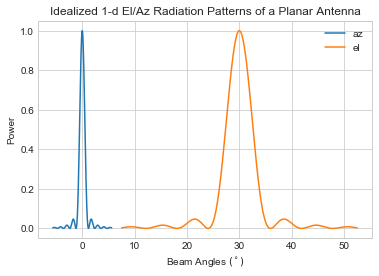

In [7]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
plt.plot(180.*theta_az/np.pi,Saz,label='az')
plt.plot(180.*theta_el/np.pi,Sel,label='el')
plt.xlabel("Beam Angles $(^\circ)$")
plt.ylabel("Power")
plt.title("Idealized 1-d El/Az Radiation Patterns of a Planar Antenna")
plt.legend(loc='best');

In [8]:
def S_p (th_az, th_el):
    return (np.sinc((th_az-theta_sq)/theta_L_a))**2 * (np.sinc((th_el-theta_l)/theta_W_a))**2

Theta_az, Theta_el = np.meshgrid(theta_az,theta_el)
S = S_p(Theta_az, Theta_el)

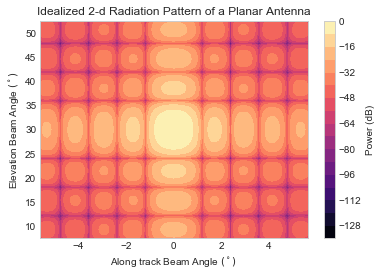

In [9]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
plt.contourf(180.*Theta_az/np.pi, 180.*Theta_el/np.pi, 10.*np.log10(S), 20, cmap='magma')
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track Beam Angle $ (^\circ)$")
plt.ylabel("Elevation Beam Angle $ (^\circ)$")
plt.title("Idealized 2-d Radiation Pattern of a Planar Antenna");

### 1.3 Beamwidth and Swath

The elevation beamwidth is the angle the beam subtends around the radar boresight in the plane perpendicular to the velocity vector. We can calculate the range $\rho$ and ground range $\rho_g$ where the boresight and the 3 dB beam edges intersect the flat Earth. Specifically, we define:

| Parameter | Symbol | 
| --- | --- | 
| Generic Range | $\rho $ |
| Generic Ground Range | $\rho_g$ |
| Range at Boresight | $\rho_l$ |
| Ground Range at Boresight | $\rho_{l,g}$ | 
| Range at Near Beam Edge | $\rho_n$ |
| Ground Range at Near Beam Edge | $\rho_{n,g}$ | 
| Range at Far Beam Edge | $\rho_f$ |
| Ground Range at Far Beam Edge | $\rho_{f,g}$ | 
| Reference azimuth for calculations | $s_0$ | 
| Reference range for calculations | $\rho_0$ | 


In [10]:
rho_l = h_sc / np.cos(theta_l)
rho_lg = h_sc * np.sin(theta_l)
rho_n = h_sc / np.cos(theta_l-theta_W_a/2)
rho_ng = h_sc * np.sin(theta_l-theta_W_a/2)
rho_f = h_sc / np.cos(theta_l+theta_W_a/2)
rho_fg = h_sc * np.sin(theta_l+theta_W_a/2)
rho_sw = rho_fg-rho_ng
Delta_rho = c / (2. * B_r)
Delta_rho_ng = Delta_rho / np.sin(theta_l-theta_W_a/2)
Delta_rho_fg = Delta_rho / np.sin(theta_l+theta_W_a/2)
n_rs=int(np.round(rho_sw/Delta_rho))
rho_v=np.linspace(rho_n,rho_f,n_rs)
s_0 = 0.   # reference azimuth for defining calculations
rho_0 = rho_l  

From these ranges, we can calculate the swath extent in meters on the ground $\rho_{fg}-\rho_{ng}$.

In [11]:
print("Boresight range: ","{:.2f}".format(rho_l),"m")
print("Range swath: ","{:.2f}".format(rho_sw),"m")

Boresight range:  866025.40 m
Range swath:  67467.65 m


The along track beam extent on the ground in meters is given by $\rho \theta_{L_a}$, where $\rho$ varies across the swath. In the near range, the azimuth beam extent is

In [12]:
print("Near range azimuth beam extent: ","{:.2f}".format(rho_n * theta_L_a),"m")

Near range azimuth beam extent:  17498.39 m


while in the far range, the azimuth beam extent is

In [13]:
print("Far range azimuth beam extent: ","{:.2f}".format(rho_f * theta_L_a),"m")

Far range azimuth beam extent:  18581.74 m


We will use the far range azimuth beamwidth to define the simulation extent in azimuth. Let's specify an extent that is 3 beamwidths to get a number of full synthetic apertures. 

| Parameter | Symbol | 
| --- | --- | 
| Along Track Position Half Beamwidth In Advance of $s_0$ | $s_{s,{\rm hb}} $ |
| Along Track Position Half Beamwidth After $s_0$ | $s_{e,{\rm hb}} $ |
| Along Track Position At Simulation Start | $s_{s,{\rm sim}}$ |
| Along Track Position at Simulation End   | $s_{e,{\rm sim}}$ | 

where
\begin{equation}
\begin{array}{lr}
s_{s,{\rm hb}} & = & s_0 - \rho_f \theta_{L_a} / 2 \\
s_{e,{\rm hb}} & = & s_0 + \rho_f \theta_{L_a} / 2 \\
s_{s,{\rm sim}} & = & s_0 - 3 \rho_f \theta_{L_a} / 2 \\
s_{e,{\rm sim}} & = & s_0 + 3 \rho_f \theta_{L_a} / 2 \\
\end{array}
\end{equation}

In [14]:
s_s_hb  = s_0 -      rho_f * theta_L_a / 2.   # half beamwidth
s_e_hb  = s_0 +      rho_f * theta_L_a / 2.   # half beamwidth
s_s_sim = s_0 - 3. * rho_f * theta_L_a / 2.   # total of 3 beamwidths for simulation
s_e_sim = s_0 + 3. * rho_f * theta_L_a / 2.   # total of 3 beamwidths for simulation

### 1.4 Phase and Doppler Frequency 

Let's pick a bright point on the ground, say at $(\rho_0, s_0)$, or equivalently $(\rho_{0g}, s_0)$. As the spacecraft flies along track and observes the point, the distance from the spacecraft to the point is changing hyperbolically: 


\begin{equation}
\rho(s;\rho_0,s_0) = \sqrt{(s-s_0)^2+\rho_0^2}
\end{equation}

The phase of the wave that travels from the spacecraft to the ground point and back is $-\frac{4 \pi}{\lambda} \rho(s)$. Over the extent of time that this point is illuminated, the range at which the point will appear in the echo, and the phase of the point, will vary as plotted below. To make the plot we need to understand how to properly sample the function we are plotting.  Since the functions are hyperbolic, the range and phase increase quasi-quadratically.  The derivative of the phase is the frequency, and this then varies quasi-linearly.  This implies that there is bandwidth associated with the received signal in azimuth, related to the fact that the radar is moving relative to the point on the ground, so there is a Doppler shift of the signal that varies as the azimuth aspect angle changes.  We will see later that the Doppler bandwidth is given approximately by the velocity and the azimuth antenna length: $B_d = 2 v_{sc} / L_a$.

In [15]:
B_d = 2. * v_sc / L_a

In [16]:
print("Doppler Bandwidth: ","{:.2f}".format(B_d),"Hz")    # in Hz or cycles/second

Doppler Bandwidth:  1500.00 Hz


Therefore if we want to sample a signal properly, we need to sample at this frequency for complex signals, or twice for real signals according to the Nyquist criterion.  

The azimuth aperture time for any target is related to the azimuth extent on the ground: $t_a = \rho * \theta_{L_a} / v_{sc}$.

In [17]:
t_af = rho_f * theta_L_a / v_sc

In [18]:
print("Synthetic Aperture time in far range: ","{:.2f}".format(t_af),"sec")

Synthetic Aperture time in far range:  2.48 sec


The time-bandwidth product gives the number of points needed to adequately represent the signal over this frequency range.

In [19]:
n_af = int(np.round(B_d * t_af))

To examine the function, we need to pick a point for the point target.  Let's assume $s_0=0$ and $\rho_0 = \rho_l$. We also remove the large offset phase $-4 \pi \rho_0 / \lambda$, since the absolute phase is difficult to measure and arbitrary.

\begin{equation}
\phi_{az}(s;\rho_0,s_0)  = -\frac{4\pi}{\lambda} (\rho(s;\rho_0,s_0) - \rho_0) = -\frac{4\pi}{\lambda} (\sqrt{(s-s_0)^2+\rho_0^2} - \rho_0)
\end{equation}

Assuming $(s-s_0) << \rho_0$, we can expand the square root by Taylor expansion to obtain

\begin{equation}
\phi_{az}(s;\rho_0,s_0) \approx -\frac{4\pi}{\lambda} \frac{1}{2}\frac{(s-s_0)^2}{\rho_0}
\end{equation}

which illustrates the quadratic nature of the phase to first order. 

The spatial frequency in radians is then its derivative with $s$

\begin{equation}
\omega_{az}(s;\rho_0,s_0) = -\frac{4\pi}{\lambda} \frac{(s-s_0)}{\rho_0}
\end{equation}

or in cycles

\begin{equation}
f_{az}(s;\rho_0,s_0) = -\frac{2}{\lambda} \frac{(s-s_0)}{\rho_0}
\end{equation}

or in Hertz

\begin{equation}
f_{az,hz}(s;\rho_0,s_0) = -\frac{2 v_{sc}}{\lambda} \frac{(s-s_0)}{\rho_0}
\end{equation}




In [20]:
s = np.linspace(s_s_hb, s_e_hb, n_af)
phi_az = - ( 4. * np.pi * (np.sqrt(np.square(s-s_0)+rho_0*rho_0) / Lambda) - 4. * np.pi * rho_0 / Lambda)
phi_az_approx = -4. * np.pi * np.square(s-s_0) /(2*Lambda*rho_0)
f_az_hz = - (2. * v_sc / Lambda) * (s-s_0) / rho_0

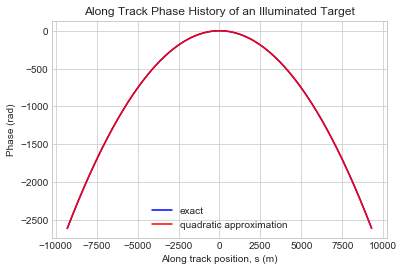

In [21]:
plt.title("Along Track Phase History of an Illuminated Target")
plt.xlabel("Along track position, s (m)")
plt.ylabel("Phase (rad)")
plt.plot(s, phi_az, 'b', label="exact")
plt.plot(s, phi_az_approx, 'r', label="quadratic approximation")
plt.legend(loc='best');

At this scale, the exact and approximate curves are indistinquishable. To see how bad the approximation is, plot the difference

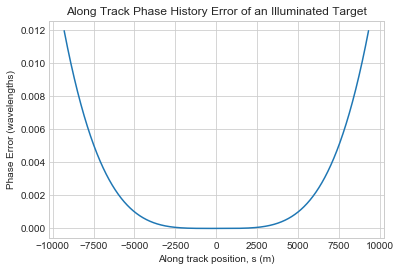

In [22]:
plt.title("Along Track Phase History Error of an Illuminated Target")
plt.xlabel("Along track position, s (m)")
plt.ylabel("Phase Error (wavelengths)")

plt.plot(s, (phi_az-phi_az_approx)/(2.*np.pi));

The Doppler bandwidth would be the range of the frequency function over this azimuth extent.

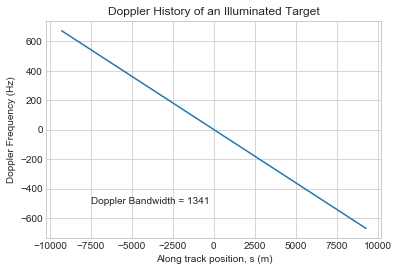

In [23]:
plt.title("Doppler History of an Illuminated Target")
plt.xlabel("Along track position, s (m)")
plt.ylabel("Doppler Frequency (Hz)")

plt.plot(s, f_az_hz)
f_az_hz_bw = np.abs(f_az_hz[-1] - f_az_hz[0])
db_str = str(int(np.round(f_az_hz_bw)))
plt.text(-7500.,-500.,"Doppler Bandwidth = "+db_str);

### Azimuth Resolution

Given this bandwidth, what does this imply for resolution in azimuth? The time resolution is simply the reciprocal bandwidth: $ 1/f_{az,hz,bw}$, where $f_{az,hz,bw} = f_{az,hz}(s_{e,\rm hb}) - f_{az,hz}(s_{s,\rm hb})$. The spatial resolution would then be the velocity times this quantity: $ v_{sc}/f_{az,hz,bw}$.

In [24]:
print('Azimuth Resolution based on Doppler Bandwidth = ',np.round(100.*v_sc/f_az_hz_bw)/100.,' m')

Azimuth Resolution based on Doppler Bandwidth =  5.59  m


The theoretical resolution is typically quoted as $L_a/2$, half the antenna length in azimuth, independent of range and frequency.  This can be seen by evaluating $f_{az,hz,bw}$ as follows:

\begin{eqnarray}
f_{az,bw} &=& | f_{az}(s_{e,\rm hb}) - f_{azz}(s_{s,\rm hb}) |\\
          &=& \frac{2}{\lambda} \frac{(s_{e,\rm hb}-s_{s,\rm hb})}{\rho_0}\\
          &=& \frac{2}{\lambda} \theta_{L_a} = -\frac{2}{\lambda} * 0.88 \frac{\lambda}{L_a} 
          &=& 0.88 \frac{2}{L_a}
\end{eqnarray}

In [25]:
print('Azimuth Resolution from calculation = ',np.round(100.*L_a/1.76)/100.,' m')

Azimuth Resolution from calculation =  5.68  m


The "L/2" azimuth resolution rule is an approximation, that will depend on the exact shape of the antenna pattern.  But it is a good first approximation.

### 1.6 The Radar Equation 

Before we proceed with simulating an image with point targets, let's take a small diversion to develop an intuition about imaging performance for a radar with particular characteristics. This is typically accomplished through the radar equation, which calculates the signal-to-noise ratio of a system for a given scatterer on the ground.  In this exercise, we'll consider a corner reflector as a scatterer.

The Radar Equation can be expressed as follows:

\begin{equation}
P_R = P_T \cdot G_T \cdot \frac{1}{4 \pi \rho^2} \cdot \sigma \cdot \frac{1}{4 \pi \rho^2} \cdot A_a \cdot \epsilon
\end{equation}

where the terms are defined as follows:

| Parameter |  Symbol | 
| --- | --- :| 
| Received Power | $P_R$ |
| Transmitted Power | $P_T$ |
| Antenna Transmit Gain | $G_T$ |
| Range of Target | $\rho$ |
| Radar Cross Section of Target | $\sigma$ |
| Receive Antenna Area |$ A_a$ |
| System Losses Fudge Factor | $\epsilon$ |

This equation from left to right follows the transmitted signal through its echo path.  The Antenna radiates a total power of $P_T$ from the aperture. That power is directed into the antenna beam by virtue of its size, and therefore has directivity: a concentration, or gain $G_T$ in a particular direction.  This power then propagates a distance  $\rho$, spreading out over a spherically shaped surface within the beam. At the target, the power density then is 

$P_T \cdot G_T \cdot \frac{1}{4 \pi \rho^2}$.

The target presents a reflecting surface which is characterized by its radar cross section.  The radar cross section is the effective area that would lead to the observed total power reflected from a target hit with an incident power density. Thus, the reflected power at the target is

$P_T \cdot G_T \cdot \frac{1}{4 \pi \rho^2} \cdot \sigma$.  

This power then propagates back to the radar as a spherical wave, such that the power density at the radar is 

$P_T \cdot G_T \cdot \frac{1}{4 \pi \rho^2} \cdot \sigma \cdot \frac{1}{4 \pi \rho^2}. $

This power density hits the receive aperture, which collects the power over its area $A_a$.  The system losses fudge factor accounts for losses of power in the receive chain before the signal is detected and may include transmit chain losses as well, depending on the definition of $P_T$ (is it the radiated power, or the power generated by the amplifiers which then needs to work its way through the antenna system to be radiated?).  Typical system losses include: circulator losses, radiation inefficiency of the antenna, and antenna feed losses.  These losses can be many factors of 2 loss in overall power generated by the radar power system. (There also are inefficiencies in getting the power from the spacecraft power system to the radar, but those are not included here.) 

To calculate the received power, we need to define a target.  In this tutorial, we are looking at corner reflectors. A corner reflector has a radar cross section 

\begin{equation}
\sigma_{cr} = \frac{4 \pi L_{cr}^4}{3\lambda^2}.
\end{equation}

We also need an expression for the gain of the antenna and the receive aperture size, which will be dependent on the look direction.  The gain in the boresight direction $G_{Tl}$ is characterized by the beamwidths of the antenna:

\begin{equation}
G_{Tl} = \frac{4 \pi}{\theta_{L_a}\theta_{W_a}}.
\end{equation}

Off boresight, this gain will be reduced by the shape of the beam pattern on both transmit and on receive $S(\theta_{az}, \theta_{el}; \theta_l, \theta_{sq})^2$ (as opposed to just $S$).

\begin{equation}
G_T(\theta_{az}, \theta_{el}; \theta_l, \theta_{sq}) = G_{Tl} S^2(\theta_{az}, \theta_{el}; \theta_l, \theta_{sq}).
\end{equation}

In [26]:
G_Tl = 4 * np.pi /(theta_L_a * theta_W_a)

In [27]:
print ("Transmit antenna gain = ","{:.2f}".format(10.*np.log10(G_Tl)),"dB") # since all quantities are powers already, this is the power gain in dB.

Transmit antenna gain =  37.65 dB


For a corner reflector target located on ground at the boresight angle, we can calculate the receive power:

In [28]:
sigma_cr = 4. * np.pi *L_cr**4/(3.*Lambda**2)  
A_a = L_a * W_a 
epsilon = 10.**(-5./10.)  # assume 5 dB overall losses
P_R = P_T * G_Tl * (1./(4.*np.pi*rho_l**2)) * sigma_cr * (1./(4.*np.pi*rho_l**2)) * A_a * epsilon

In [29]:
print ("Received power of corner reflector = ","{:.2f}".format(10.*np.log10(P_R)),"dB") # in dB

Received power of corner reflector =  -143.98 dB


In order for the instrument to detect such a small amount of power, the noise level of the system must be commensurately small.  The noise of an electronic system is given by 

\begin{equation}
P_N = k T_r B_r
\end{equation}

where $k$ is the Boltzman constant, $T_r$ is the noise temperature of the radar, and $B_r$ is the bandwidth of the radar (Skolnik, Merrill I., Radar Handbook (2nd Edition). McGraw-Hill, 1990. ISBN 978-0-07-057913-2). The noise temperature is not necessarily the physical temperature.  It is a combination of noise introduced by electron motion in electronics above absolute zero temperature and other noise sources. A reasonable noise temperature would be around 300 K.

In [30]:
P_N = k* T_r * B_r

In [31]:
print ("Noise power = ","{:.2f}".format(10.*np.log10(P_N)),"dB")

Noise power =  -130.82 dB


In [32]:
SNR = P_R/P_N

In [33]:
print("SNR of corner reflector in raw data  = ","{:.2f}".format(10.*np.log10(SNR)),"dB")

SNR of corner reflector in raw data  =  -13.16 dB


It looks like the SNR of a bright point target is well below the noise floor in this radar, and that is in general true in the raw data.  The signals from individual scatterers or resolution cells in the raw data are quite dim.  It is not until we focus the image that we concentrate the energy into a single point and build adequate SNR.

<a id="section-2"></a>
## 2.0 Simulating SAR data with point targets 

<a id="section-2.1"></a>
### 2.1 Simulating the transmitted pulse

Our radar will transmit pulses of energy at a pulse rate $f_r$ sufficient to sample the Doppler spectrum, the bandwidth of which was computed above.  For our purposes, the pulse rate is set slightly higher than the Doppler bandwidth, which lowers aliasing of the energy outside this area of the spectrum.  For any given pulse, we transmit a pulse of duration $\tau_r$, sweeping the frequency linearly, to generate a signal with the required bandwidth $B_r$.  The time-bandwidth product determine the number of samples required in this complex signal. Note: in reality we transmit and receive real-valued waveforms as currents excited or detected on the antenna.  However, radar systems are coherent by nature, and the received signals are typically converted in hardware or on the ground to complex-valued waveforms.  For this tutorial, we imagine that the transmit waveform is complex for simplicity. The frequency-swept, or "chirp," waveform can be expressed as

$C_r(t) = e^{i \phi_r(t)} {\rm rect}\big(\frac{t}{\tau_r}\big)$ where $\phi_r(t) = \pi \frac{B_r}{\tau_r} t^2 = \pi \frac{B_r}{\tau_r} (2\rho/c)^2 = 4 \pi \frac{B_r}{c^2\tau_r} \rho^2$, and the rect function is 1 on the interval 0 to 1, and 0 elsewhere.  First, let's define these functions:

In [34]:
def rect(x):
    return np.abs(x) <= 0.5   
def win(x):
    return 1. # rectangular window
#    return 0.54 - 0.46 * np.cos(2.*np.pi*(x+0.5))  # hamming window defined on [-0.5,0.5] applied to suppress sidelobes.

def C_r_r(r):
    phi_r_r = 4. * np.pi * B_r  / (c**2 * tau_r) * r**2
    return (np.cos(phi_r_r) + 1j * np.sin(phi_r_r)) * rect((r- c*tau_r/4.)/(c * tau_r/2.)) * win((r- c*tau_r/4.)/(c * tau_r/2.))

Now let's evaluate the chirp over the pulse length and examine some of its properties.  The required number of samples is again the time-bandwidth product of the chirp.

In [35]:
n_r = int(np.round(B_r * tau_r))  
t_c = np.linspace(0.,tau_r,2*n_r) # create the arrays with twice the required points so real functions don't alias
rho_c = c * t_c / 2.
C_r = C_r_r(rho_c)
phi_r = 4. * np.pi * B_r  / (c**2 * tau_r) * rho_c**2

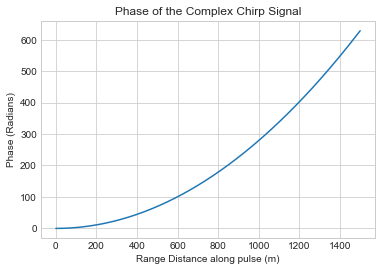

In [36]:
plt.title("Phase of the Complex Chirp Signal")
plt.xlabel("Range Distance along pulse (m)")
plt.ylabel("Phase (Radians)")
plt.plot(rho_c,phi_r);

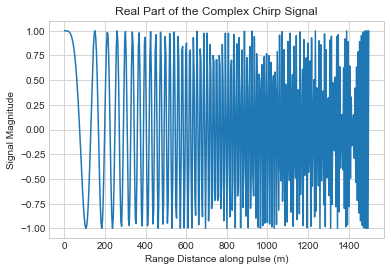

In [37]:
plt.title("Real Part of the Complex Chirp Signal")
plt.xlabel("Range Distance along pulse (m)")
plt.ylabel("Signal Magnitude")
plt.plot(rho_c,C_r.real);

Feel free to play with the plotting limits of the array to explore the shape of the curve.  Note that the complex chirp as created with twice the number of needed samples so that plotting the real or imaginary part, which is sinusoidal with increasing frequency, looks properly sampled in the plot.  In reality, it is well sampled in the complex domain with half the point density.

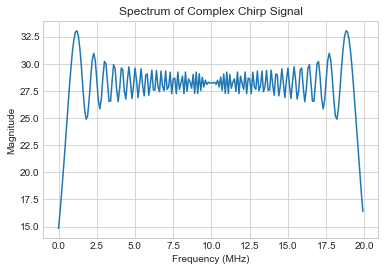

In [38]:
plt.title("Spectrum of Complex Chirp Signal")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")
FC_r = np.fft.fft(C_r)
freq = np.fft.fftfreq(FC_r.shape[-1])
nplts = int(np.round(FC_r.shape[-1]/2))  # only need the positive frequencies since it is a complex signal.
plt.plot(freq[0:nplts]*2.*B_r/1.e6, np.absolute(FC_r[0:nplts]));  # factor of 2 because time domain signal is oversampled

<a id="section-2.2"></a>
### 2.2 Simulating the Received Echoes

Now we have a chirp signal, and when it encounters our corner reflector target, it will reflect some energy back to the radar. The echo signature of a corner reflector will be a delayed version of itself, with amplitude adjusted based on the shape of the antenna pattern and the losses as calculated in the radar equation above, and a phase shift proportional to the round-trip distance $2 \rho$. Specifically, for a corner refector at $s_{cr},\rho_{cr}$, the received echo will be:

\begin{equation}
E_{cr}(s,\rho; s_{cr},\rho_{cr}) = \sqrt{G_T\big(\theta_{az,cr}(s;s_{cr},\rho_{cr}), \theta_{el,cr}(\rho_{cr}); \theta_{l}, \theta_{sq}\big )} e^{-i 4\pi(\rho_{\rm sc-cr}-\rho_{l})/\lambda}C_r\big(2(\rho-\rho_{\rm sc-cr})/c\big)
\end{equation}

where 

$\rho_{\rm sc-cr;}(s; s_{cr},\rho_{cr}) = \sqrt{(s-s_{cr})^2+\rho_{cr}^2}$ is the distance from the spacecraft to the corner reflector,

$\theta_{az,cr} = \sin^{-1} \frac{s-s_{cr}}{\rho_{\rm sc-cr}}$ 

and

$\theta_{el,cr} = \cos^{-1}\frac{h_{sc}}{\rho_{cr}}$

and we have arbitrarily removed a large phase offset $4 \pi \rho_l / \lambda$ to make the phase numbers more manageable. The rect function indicates that the chirp extent only covers the range defined by the pulse length.

In [39]:
def E_cr(sv,rhov,s_cr,rho_cr):
    rho_sc_cr = np.sqrt((sv-s_cr)**2+rho_cr**2)
    th_el_cr = np.arccos(h_sc/rho_cr)
    th_az_cr = np.arcsin((sv-s_cr)/rho_sc_cr)
    return np.sqrt(P_R) * S_p(th_az_cr,th_el_cr) * np.exp(-1j * 4. * np.pi * (rho_sc_cr-rho_l)/Lambda) * C_r_r (rhov-rho_sc_cr)


To simulate the image, we must specify the location of the corner reflectors.  First, we define the array of locations: 3 reflectors, each at different ranges and along-track positions.  The along track positions will be at $s_0$ and a half beamwidth before and after $s_0$. The range position will be at the boresight range $\rho_l$, and an eighth of the swath before and after $\rho_l$. For the purpose of speed and flexibility, the simulation allows using any or all of the three corner reflectors through an index vector.

$P_{\rm cr} = \big [\big (s_{s,{\rm hb}},\rho_l-\frac{\rho_f-\rho_n}{8}\big),(s_0,\rho_l),\big(s_{e,{\rm hb}},\rho_l+\frac{\rho_f-\rho_n}{8}\big) \big ]$

In [40]:
S_cr = np.array([s_s_hb,s_0,s_e_hb],dtype='float64')
Rho_cr = np.array([rho_l-(rho_f-rho_n)/8.,rho_l,rho_l+(rho_f-rho_n)/8.],dtype='float64')
Ind_cr=[1]

Now it is time to define the grid for computing the simulated data; this will be over a portion range that covers the corner reflectors (to save computation time) and the along track extend define $s_{s,{\rm sim}}$ and $s_{s,{\rm sim}}$, which is specified in terms of the number of along-track beamwidths. The along track sample spacing is nominally set by the PRF $f_p$ as $\Delta s = v_{sc}/f_p$.  The range spacing is nominally set by the range bandwidth $\Delta\rho = c / 2B_R$.  For both dimensions, we allow an oversampling factor so that we can easily examine the results without interpolating the results.

In [41]:
s_ov = 1.
rho_ov = 4.
Delta_s = v_sc/f_p
n_s_sim = int(np.round((s_e_sim-s_s_sim)*s_ov/Delta_s))
s_sim = np.linspace(s_s_sim, s_e_sim, n_s_sim)
rho_mean = (rho_f+rho_n)/2.
rho_s_sim = rho_mean - (rho_f-rho_n)/4. # central half of swath
rho_e_sim = rho_mean + (rho_f-rho_n)/4. # central half of swath
#this is the default for range extent.  We can narrow further to just surrounding the CRs
Rho_cr_min = rho_f
Rho_cr_max = rho_n
for i in range(len(Ind_cr)):
    Rho_cr_min=np.minimum(Rho_cr[Ind_cr[i]],Rho_cr_min)
for i in range(len(Ind_cr)):
    Rho_cr_max=np.maximum(Rho_cr[Ind_cr[i]],Rho_cr_max)
rho_s_sim =  Rho_cr_min - 4.* c* tau_r/2.
rho_e_sim =  Rho_cr_max + 4.* c* tau_r/2.
n_rho_sim = int(np.round((rho_e_sim-rho_s_sim)*rho_ov/Delta_rho))

rho_sim = np.linspace(rho_s_sim, rho_e_sim, n_rho_sim)
S_sim, Rho_sim = np.meshgrid(s_sim,rho_sim)

Let's look at the corner reflectors on the grid

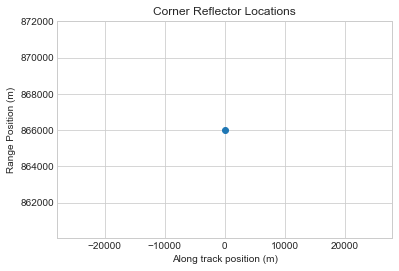

In [42]:
plt.scatter(S_cr,Rho_cr, cmap='magma')
plt.xlabel("Along track position (m)")
plt.ylabel("Range Position (m)")
plt.title("Corner Reflector Locations")
plt.xlim(s_s_sim,s_e_sim)
plt.ylim(rho_s_sim,rho_e_sim);


With the grid defined, we can simply evaluate $E_{cr}$ over the grid.

In [43]:
%%time
E_cr_sim = np.zeros(S_sim.shape,dtype=np.complex128)
print ("Field initialized")
for i in range(len(Ind_cr)):
    E_cr_sim += E_cr(S_sim,Rho_sim,S_cr[Ind_cr[i]],Rho_cr[Ind_cr[i]])
    print("Completed CR",i)

Field initialized
Completed CR 0
CPU times: user 13.9 s, sys: 9.05 s, total: 22.9 s
Wall time: 23 s


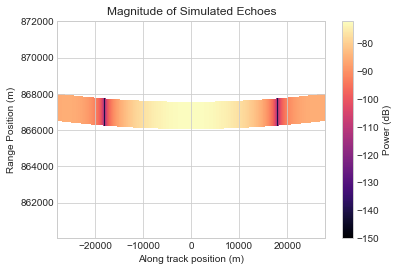

In [44]:
#plt.contourf(S_sim, Rho_sim, 10.*np.log10(np.absolute(E_cr_sim)), 20, cmap='RdGy')
#plt.pcolormesh(S_sim, Rho_sim, 10.*np.log10(np.absolute(E_cr_sim)),cmap='RdGy')
extent = [s_s_sim, s_e_sim, rho_s_sim, rho_e_sim]
plt.imshow(10.*np.log10(np.abs(E_cr_sim)), cmap='magma', extent=extent, origin='lower', aspect='auto')
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (m)")
plt.ylabel("Range Position (m)")
plt.title("Magnitude of Simulated Echoes");


Now let's look at these echoes in the presence of the thermal noise signature, with a field with noise power $k T B_r$.


In [45]:
np.random.seed(1)
E_cr_sim_w_noise = E_cr_sim + np.random.normal(loc=0.,scale=np.sqrt(P_N/2.),size=S_sim.shape) + 1j * np.random.normal(loc=0.,scale=np.sqrt(P_N/2.),size=S_sim.shape)
print ("Random field calculated")

Random field calculated


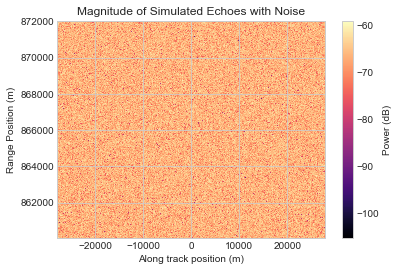

In [46]:
plt.imshow(10.*np.log10(np.abs(E_cr_sim_w_noise)), cmap='magma', extent=extent, origin='lower', aspect='auto')
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (m)")
plt.ylabel("Range Position (m)")
plt.title("Magnitude of Simulated Echoes with Noise");


As can be seen, these signals are buried in the noise.  They don't pop out until we focus the image, taking advantage of the redundancy in observing any single target over a wide beam in azimuth, and a wide pulse in range.  So it is time to focus the data.

<a id="section-3"></a>
## 3.0 Focusing SAR Data - Range

The straightforward approach to focusing data is to develop a means for any given target to compensate the phase variations in range and azimuth induced by the range chirp and the azimuth hyperbolic range variability and then sum up that energy.  For the isolated corner reflector target responses shown above this is easy to visualize, in that we are plotting the magnitude.  If the phase for each of these points was a constant value, it is easy to see that integrating the points in the non-zero areas would give a big integration gain.  Of course if the phase were constant everywhere, one could not distinguish one corner reflector from any other, so there would be no integration advantage.  Because the phase history in range and azimuth is unique for each scatterer on the ground, the process of compensating the phase for that specific point, then integrating the energy localizes the return from that specific point. This can be partitioned into the phase compensation and integration in range, called "range compression," or "range correlation," followed by azimuth processing.

  
<a id="section-3.1"></a>
### 3.1 Range Correlation - time domain

The range signal that matches the range response received echo of a corner reflector, is simply  
\begin{equation}
C_r\big(2(\rho-\rho_{\rm sc-cr})/c\big)  = e^{i 4 \pi \frac{B_r}{c^2\tau_r} (\rho-\rho_{\rm sc-cr} )^2} {\rm rect}\big(\frac{\rho-\rho_{\rm sc-cr}}{c \tau_r/2}\big)
\end{equation}

which is the same as the received echo $E_{cr}(s,\rho; s_{cr}, \rho_{cr})$ but without the propagation-related amplitude scale factor and phase components of the signal.

To recover the signal in range as a point, we would compute the conjugate function and integrate for each range point


\begin{equation}
E_{cr,rc}(s,\rho; s_{cr}, \rho_{cr}) = \displaystyle\int E_{cr}(s,\rho'; s_{cr}, \rho_{cr}) C^*_r(s,\rho'+\rho; s_{cr}, \rho_{cr}) d\rho'
\end{equation}

This is by definition the cross correlation of these two functions.  For corner reflector, this correlation integral can be evaluated

$
\begin{array}{ll}
E_{cr,rc} & = & \sqrt{G_T} e^{-i 4\pi(\rho_{\rm sc-cr}-\rho_{l})/\lambda} \displaystyle\int C_r(s,\rho'; s_{cr}, \rho_{cr}) C^*_r(s,\rho'+\rho; s_{cr}, \rho_{cr}) d\rho' \\
& = & \sqrt{G_T} e^{-i 4\pi(\rho_{\rm sc-cr}-\rho_{l})/\lambda} \displaystyle\int e^{i 4 \pi \frac{B_r}{c^2\tau_r} (\rho'-\rho_{\rm sc-cr} )^2} {\rm rect}\big(\frac{\rho'-\rho_{\rm sc-cr}}{c \tau_r/2}\big) e^{-i 4 \pi \frac{B_r}{c^2\tau_r} (\rho'+\rho-\rho_{\rm sc-cr} )^2} {\rm rect}\big(\frac{\rho'+\rho-\rho_{\rm sc-cr}}{c \tau_r/2}\big) d\rho' \\
& = & \sqrt{G_T} e^{-i 4\pi(\rho_{\rm sc-cr}-\rho_{l})/\lambda} e^{i 4 \pi \frac{B_r}{c^2\tau_r} (\rho^2-\rho_{\rm sc-cr}^2)} \displaystyle\int e^{i 4 \pi \frac{B_r}{c^2\tau_r} (\rho'-\rho_{\rm sc-cr} )^2} {\rm rect}\big(\frac{\rho'-\rho_{\rm sc-cr}}{c \tau_r/2}\big) {\rm rect}\big(\frac{\rho'+\rho-\rho_{\rm sc-cr}}{c \tau_r/2}\big) d\rho'
\end{array}
$


In [47]:
%%time
n_r = int(np.round(rho_ov * B_r * tau_r))  
rho_c_ov = np.linspace(0.,c*tau_r/2.,n_r)                               # properly oversample to match simulation oversampling
C_r_ref = C_r_r(rho_c_ov)                                               # compute the properly oversampled reference function
range_shape=np.correlate(E_cr_sim[:,0],C_r_ref,mode='valid').shape[0]   # perform one correlation to determine the length of the output
E_cr_rc = np.zeros((range_shape,E_cr_sim.shape[1]),dtype=np.complex128) # initialize
for i in range(E_cr_sim.shape[1]):                                      # correlate
    E_cr_rc[:,i] = np.correlate(E_cr_sim[:,i],C_r_ref,mode='valid')

CPU times: user 36.6 s, sys: 471 ms, total: 37 s
Wall time: 37.1 s


Here is the range-correlated signal over the simulation domain.

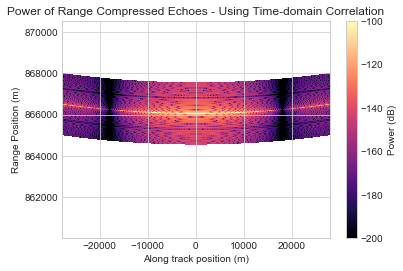

In [48]:
n_rho_rc = E_cr_rc.shape[0]
rho_s_rc = rho_s_sim
rho_e_rc = rho_sim[n_rho_rc-1]
extent = [s_s_sim, s_e_sim, rho_s_rc, rho_e_rc]
plt.imshow(20.*np.log10(np.abs(E_cr_rc)), cmap='magma', extent=extent, origin='lower', aspect='auto',vmax=-100.,vmin=-200.)
plt.xlabel("Along track position (m)")
plt.ylabel("Range Position (m)")
plt.title("Power of Range Compressed Echoes - Using Time-domain Correlation")
plt.colorbar(label='Power (dB)');


Let's look at the range correlated output centered on the along-track position of the first corner reflector in the simulation list (may be different from the first defined depending on the index array above).

In [49]:
ind_s_cr=int(np.round((S_cr[Ind_cr[0]]-s_s_sim)*s_ov/Delta_s))
ind_rho_cr=int(np.round((Rho_cr[Ind_cr[0]]-rho_s_sim)*rho_ov/Delta_rho))
E_cr_rc_1rl = E_cr_rc[:,ind_s_cr]

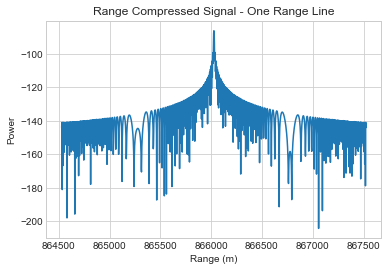

In [50]:
plt.title("Range Compressed Signal - One Range Line")
plt.xlabel("Range (m)")
plt.ylabel("Power")
plt.plot(rho_sim[0:E_cr_rc_1rl.shape[0]],20.*np.log10(np.abs(E_cr_rc_1rl)));

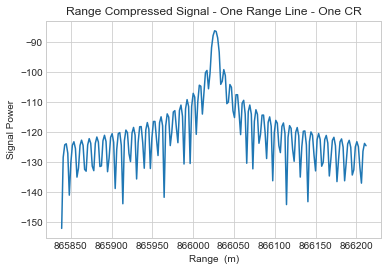

In [51]:
plt.title("Range Compressed Signal - One Range Line - One CR")
plt.xlabel("Range  (m)")
plt.ylabel("Signal Power")
sr=ind_rho_cr-100
er=ind_rho_cr+100
plt.plot(rho_sim[sr:er],20.*np.log10(np.abs(E_cr_rc[sr:er,ind_s_cr])));

<a id="section-3.2"></a>
### 3.2 Range Correlation - frequency domain

This can also be accomplished with FFT-based circular convolution, and it runs considerably faster.  To accomplish this most straightforwardly, we can create a version of the chirp that is the same length as the range vector; then when we take the FFT, both will be the same length. Subscript "rl" stands for "range line." Subscript "fd" stands for "frequency domain." First compute the reference function's spectrum:

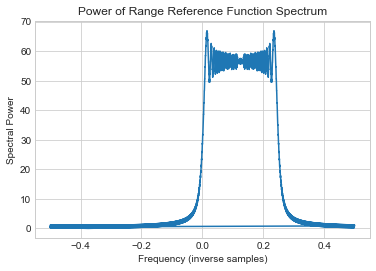

In [52]:
C_r_ref_rl = np.zeros(n_rho_sim) + 1j *np.zeros(n_rho_sim)
C_r_ref_rl[0:n_r] = C_r_ref
C_r_REF_rl = np.conjugate(np.fft.fft(C_r_ref_rl))
freq = np.fft.fftfreq(C_r_REF_rl.shape[-1])
plt.plot(freq,np.absolute(C_r_REF_rl))
plt.xlabel("Frequency (inverse samples)")
plt.ylabel("Spectral Power")
plt.title("Power of Range Reference Function Spectrum");

Now perform the correlation through circular convolution in the frequency domain.

In [53]:
%%time
E_cr_rc_fd = np.zeros((E_cr_sim.shape),dtype=np.complex128)
for i in range(E_cr_sim.shape[1]):
    E_cr_rc_fd[:,i] = np.fft.ifft(np.fft.fft(E_cr_sim[:,i])*C_r_REF_rl)

CPU times: user 6.05 s, sys: 463 ms, total: 6.52 s
Wall time: 6.52 s


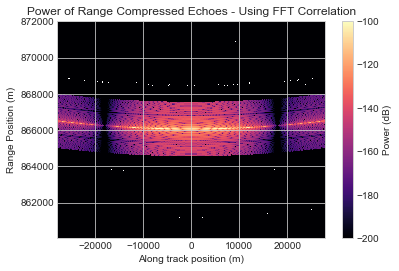

In [54]:
extent = [s_s_sim, s_e_sim, rho_s_sim, rho_e_sim]
plt.imshow(20.*np.log10(np.abs(E_cr_rc_fd)), cmap='magma', extent=extent, origin='lower', aspect='auto',vmax=-100.,vmin=-200.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (m)")
plt.ylabel("Range Position (m)")
plt.title("Power of Range Compressed Echoes - Using FFT Correlation");

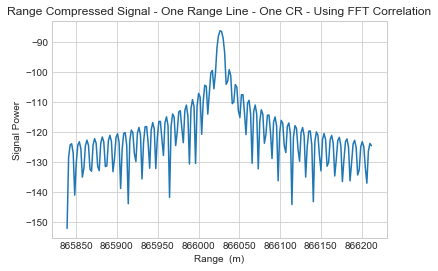

In [55]:
plt.plot(rho_sim[sr:er],20.*np.log10(np.abs(E_cr_rc_fd[sr:er,int(np.round(E_cr_rc_fd.shape[1]/2))])))
plt.title("Range Compressed Signal - One Range Line - One CR - Using FFT Correlation")
plt.xlabel("Range  (m)")
plt.ylabel("Signal Power");


<a id="section-4"></a>
## 4.0 Focusing SAR Data - Azimuth 

Now that we understand the range correlation, it is time to do the same thing in the along-track, or azimuth direction.  The complication in azimuth is that each target on the ground expresses its reflected energy at different ranges in each pulse.  This can be seen easily in the 2d plots above where the bright return in the range compressed data from a single corner reflector "migrates" through the range as a function of azimuth position - called range migration.  This is addressed typically in two ways:

1. Correlate each point on the ground with its exact hyperbolic replica, calculable from the knowledge of the radar motion.  This is called back-projection or time-domain processing, and can be quite computationally expensive.
2. Approximate the time-domain approach by working in the frequency domain to compensate for the migration, then perform a circular convolution.

We'll take these two approaches one at a time.  First let's do the frequency domain approach as it can be built step by step to illustrate the impacts of the approximations.


<a id="section-4.1"></a>
### 4.1 Azimuth reference function 

First let's look at the signal in azimuth at the peak of the range response of the first corner reflector.

In [56]:
rho_ind_cr = int(np.round((Rho_cr[Ind_cr[0]]-rho_s_sim)*rho_ov/Delta_rho))

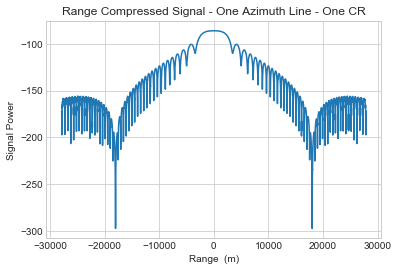

In [57]:
plt.title("Range Compressed Signal - One Azimuth Line - One CR")
plt.xlabel("Range  (m)")
plt.ylabel("Signal Power")
plt.plot(s_sim,20.*np.log10(np.abs(E_cr_rc[rho_ind_cr,:])));

The power of the received signal from a corner reflector in azimuth should follow the antenna pattern, but instead   the power at a fixed range has a plateau around the corner reflector, then diminishes in a oscillatory fashion.  These oscillations are a consequence of the fact that the range from the spacecraft to the corner reflector is changing with $s$.  When the range change is such that the peak of the response migrates out of the range bin, we will begin to see the sidelobes of the range response.  The observed null would occur at the $s$ location at which the range changes by the distance in range to the first null of the range sidelobes, which is $\Delta\rho$. Thus

$s_{null}  = \sqrt{(\rho_{cr}+\Delta\rho)^2 - \rho^2_{cr}}$

In [58]:
s_null = np.sqrt((Rho_cr[Ind_cr[0]]+Delta_rho)**2-(Rho_cr[Ind_cr[0]])**2)
print('Azimuth null position due to range migration =',np.round(100.*s_null)/100.,'m')

Azimuth null position due to range migration = 3602.98 m


which is about where it is observed in the figure above.  Let's instead track the expected location of the peak in azimuth. This is accomplished by noting that

$ \rho(s) = \sqrt{(s-s_{cr})^2+\rho^2_{cr}}$

We can use this to look up the range for any give $s$ in the range compressed data.

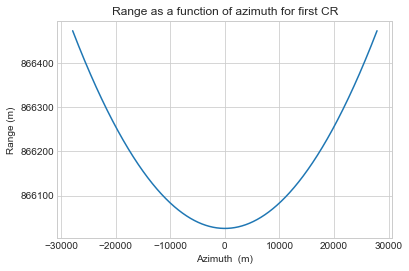

In [59]:
rho_of_s = np.sqrt((s_sim-S_cr[Ind_cr[0]])**2 + Rho_cr[Ind_cr[0]]**2)
plt.title("Range as a function of azimuth for first CR")
plt.xlabel("Azimuth  (m)")
plt.ylabel("Range (m)")
plt.plot(s_sim,rho_of_s);

Now let's plot the azimuth history at these ranges.

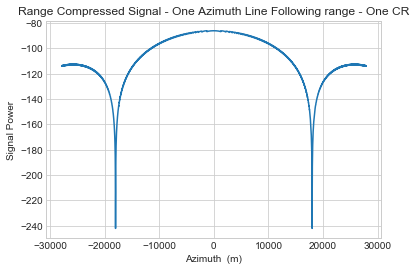

In [60]:
ind_rho_of_s = np.round((rho_of_s-rho_s_sim)*rho_ov/Delta_rho).astype(int)
E_cr_rc_1az = np.zeros(n_s_sim) + 1j *np.zeros(n_s_sim)
for i_s in range(n_s_sim):
    E_cr_rc_1az[i_s] = E_cr_rc[ind_rho_of_s[i_s],i_s]
plt.title("Range Compressed Signal - One Azimuth Line Following range - One CR")
plt.xlabel("Azimuth  (m)")
plt.ylabel("Signal Power")
plt.plot(s_sim,20.*np.log10(np.abs(E_cr_rc_1az)));

This looks more like the antenna pattern should, indicating we are tracking the range migration well.  It should have a quadratic variation of phase across azimuth.

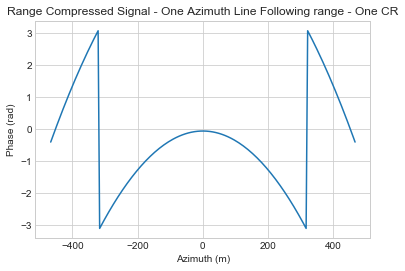

In [61]:
plt.title("Range Compressed Signal - One Azimuth Line Following range - One CR")
plt.xlabel("Azimuth (m)")
plt.ylabel("Phase (rad)")
ss = int(n_s_sim/2)-100
se = int(n_s_sim/2)+100

plt.plot(s_sim[ss:se],np.arctan2(np.imag(E_cr_rc_1az[ss:se]),np.real(E_cr_rc_1az[ss:se])));

This looks like a wrapped quadratic, so all is well.  This phase will be the basis for the azimuth reference function.

<a id="section-4.2"></a>
### 4.2 Azimuth Focusing - time domain

#### Coarsest Approximation: Straight Time-domain Correlation with a Constant Reference Function

The idea here is to assume that the azimuth reference function is as simple and constant as the range reference function.  In this case, we can just perform a simple time domain correlation in azimuth.  This ignores range migration, and the variation in range migration magnitude as a function of range.  For small synthetic apertures and coarse range resolution, this may be adequate. Let's see how bad it can be.  Let's use the mid-range as our reference and calculate the azimuth response there over the synthetic aperture.  We'll then use that single function to correlate each of the range bins in the simulated range compressed pulse sequence and see what happens.

In [62]:
%%time

s_s_sa  =  rho_l * np.tan(theta_sq-theta_L_a/2.) # half beamwidth, w/ squint, relative to s_im
s_e_sa  =  rho_l * np.tan(theta_sq+theta_L_a/2.) # half beamwidth, w/ squint, relative to s_im
n_s_sa = np.round((s_e_sa-s_s_sa)* s_ov/Delta_s).astype(int)
s_sa = np.linspace(s_s_sa,s_e_sa,n_s_sa)
rho_sa = np.sqrt(rho_l**2+(s_sa)**2)
C_az_ref = np.exp(-1j*4.*np.pi*rho_sa/Lambda) # correlate of observed phase history
az_shape=np.correlate(E_cr_rc[0,:],C_az_ref,mode='full').shape[0]  # perform one correlation to determine the length of the output
E_cr_rcac = np.zeros((E_cr_rc.shape[0],az_shape),dtype=np.complex128) # initialize
for i in range(E_cr_rc.shape[0]):                                      # correlate
    E_cr_rcac[i,:] = np.correlate(E_cr_rc[i,:],C_az_ref,mode='full')

CPU times: user 2min 33s, sys: 691 ms, total: 2min 33s
Wall time: 2min 34s


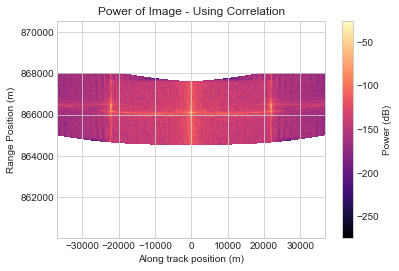

In [63]:
plt.title("Power of Image - Using Correlation")
plt.xlabel("Along track position (m)")
plt.ylabel("Range Position (m)")
extent = [s_s_sim-Delta_s*n_s_sa/2./s_ov, s_e_sim+Delta_s*n_s_sa/2./s_ov, rho_s_rc, rho_e_rc]
plt.imshow(20.*np.log10(np.abs(E_cr_rcac)), cmap='magma', extent=extent, origin='lower', aspect='auto')
plt.colorbar(label='Power (dB)');


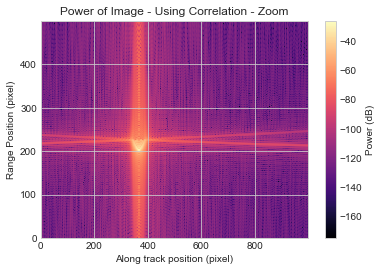

In [64]:
plt.title("Power of Image - Using Correlation - Zoom")
plt.xlabel("Along track position (pixel)")
plt.ylabel("Range Position (pixel)")
plt.imshow(20.*np.log10(np.abs(E_cr_rcac[3000:3500,7500:8500])), cmap='magma', origin='lower', aspect='auto')
plt.colorbar(label='Power (dB)');

Not exactly a perfect corner reflector response, but energy was certainly concentrated. Note also the extra energy focused at 1/4 and 3/4 of the distance across the image.  These are azimuth ambiguities, where the energy present outside the main lobe of the antenna is focused at an amplitude attenuated by the antenna pattern. These should occur at the azimuth location where the next stationary phase point is in the aliased signal, which is dependent on the exact sampling rate relative to the phase rate of the signal.  Their appearance at ~ +/- 21 km is about right.

#### Next Coarsest Approximation: Straight Time-domain Correlation with a Range-variable Reference Function

Here we emphasize the notion that the reference function varies with range.  Even though we are not taking into account range migration, we have a better match to the phase at a given range.  We calculate the range variable reference function as a matrix, and keep it handy for the circular convolution step to come.  This is a little tricky since the limits of the synthetic aperture change with range and we want the convolutions to be consistently aligned across range.  So we must first create an array of the same length in azimuth as the number of pulses, then populate the array accordingly.

The synthetic aperture extents vary with range, and need to take into account any azimuth squint. For a point at $(s_{im},\rho_{im})$ observed with squint $\theta_{sq}$, the range of closest approach of the spacecraft when the boresight intersects this point is given by

$ \rho_{ca} = \rho_{im} \cos\theta_{sq}$ 

and the along-track position of this point relative to closest approach is

$s_{ca} = \rho_{ca} \tan \theta_{sq}$

The limits of the synthetic aperture then are given by the angle subtended around this squint angle:

$s_{s,sa} = \rho_{ca} \tan (\theta_{sq} - \theta_{L_a}/2) \qquad s_{e,sa} = \rho_{ca} \tan (\theta_{sq} + \theta_{L_a}/2)$

$\rho_{s,sa} = \rho_{ca} / \cos(\theta_{sq}-\theta_{L_a}/2) \qquad \rho_{e,sa} = \rho_{ca} / \cos(\theta_{sq}+\theta_{L_a}/2)$

With these limits, the task is now to fill an array with a full set of range-dependent reference functions. The tricky part is calculating the functions on a regular grid with limits that vary with range.  There is a lot of indexing and limit checking consequently.


In [65]:
# calculate closest approach range and azimuth position for squinted geometry

rho_rc = rho_sim[0:n_rho_rc]
rho_ca = rho_rc * np.cos(theta_sq)
s_ca = rho_ca * np.tan(theta_sq)

#define the synthetic aperture extents across range

s_s_sa_v_rho  =  rho_ca * np.tan(theta_sq-theta_L_a/2.) # half beamwidth, w/ squint, relative to s_im
s_e_sa_v_rho  =  rho_ca * np.tan(theta_sq+theta_L_a/2.) # half beamwidth, w/ squint, relative to s_im
n_s_sa_v_rho = np.round((s_e_sa_v_rho-s_s_sa_v_rho)* s_ov/Delta_s).astype(int)

rho_s_sa_v_rho = rho_ca / np.cos(theta_sq-theta_L_a/2)
rho_e_sa_v_rho = rho_ca / np.cos(theta_sq+theta_L_a/2)
n_rho_sa_v_rho = np.round((rho_e_sa_v_rho-rho_s_sa_v_rho)* s_ov/Delta_s).astype(int)

# calculate the indices along track that define the limits for each range.

ind_s_s_sa_v_rho = np.round((s_s_sa_v_rho-s_0)/(Delta_s/s_ov)).astype(int)
ind_s_e_sa_v_rho = np.round((s_e_sa_v_rho-s_0)/(Delta_s/s_ov)).astype(int)

In [66]:
# to define the reference function array, find the maximum extent needed

n_s_sa_v_rho = (ind_s_e_sa_v_rho-ind_s_s_sa_v_rho)+1
n_s_sa_v_rho_max = np.max(n_s_sa_v_rho)
ind_s_s_sa_v_rho_min = np.min(ind_s_s_sa_v_rho)
ind_s_e_sa_v_rho_max = np.max(ind_s_e_sa_v_rho)

# now calculate the reference function placed consistently in the oversized array

s_s_sa = s_0 + ind_s_s_sa_v_rho*Delta_s/s_ov
s_e_sa = s_0 + ind_s_e_sa_v_rho*Delta_s/s_ov

# initialize the reference array

C_az_ref = np.zeros((n_rho_rc,n_s_sa_v_rho_max),dtype=np.complex128)

# populate the reference array

for i in range(n_rho_rc):  
    s_sa = np.linspace(s_s_sa[i],s_e_sa[i],n_s_sa_v_rho[i])
    rho_sa = np.sqrt(rho_ca[i]**2+(s_sa)**2)
    ssind = ind_s_s_sa_v_rho[i]-ind_s_s_sa_v_rho_min
    seind = ind_s_e_sa_v_rho[i]-ind_s_s_sa_v_rho_min
    C_az_ref[i,ssind:seind+1] = np.exp(-1j*4.*np.pi*rho_sa/Lambda) # correlate of observed phase history

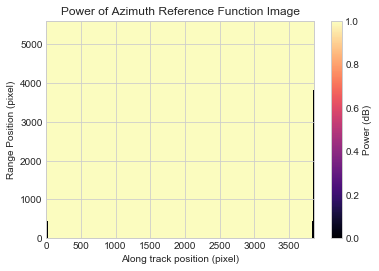

In [67]:
plt.imshow((np.abs(C_az_ref)), cmap='magma', origin='lower', aspect='auto')
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Power of Azimuth Reference Function Image");

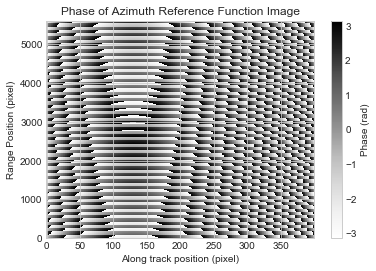

In [68]:
plt.imshow(np.arctan2(np.imag(C_az_ref[:,1800:2200]),np.real(C_az_ref[:,1800:2200])), origin='lower', aspect='auto')
plt.colorbar(label='Phase (rad)');
plt.xlabel("Along track position (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Phase of Azimuth Reference Function Image");

The jittery appearance of this image is due to the fact that the phase reference is changing rapidly as a function of range, and given the sampling in range, the sampling is not regular relative to the phase wrapping rate.  Therefore to see a smoother version of this image, one needs to unwrap the image. 

In [69]:
%%time

# finally do the correlation

az_shape=np.correlate(E_cr_rc[0,:],C_az_ref[0,:],mode='full').shape[0]  # perform one correlation to determine the length of the output
E_cr_rcac2 = np.zeros((n_rho_rc,az_shape),dtype=np.complex128) # initialize
for i in range(n_rho_rc):                                      # correlate
    E_cr_rcac2[i,:] = np.correlate(E_cr_rc[i,:],C_az_ref[i,:],mode='full')

CPU times: user 2min 37s, sys: 860 ms, total: 2min 38s
Wall time: 2min 38s


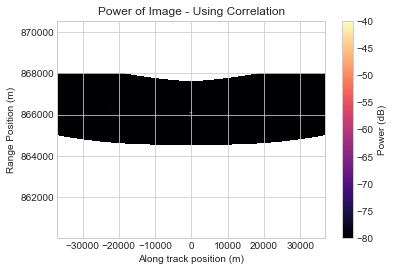

In [70]:
extent = [s_s_sim-Delta_s*n_s_sa_v_rho_max/2./s_ov, s_e_sim+Delta_s*n_s_sa_v_rho_max/2./s_ov, rho_s_rc, rho_e_rc]
plt.xlabel("Along track position (m)")
plt.ylabel("Range Position (m)")
plt.title("Power of Image - Using Correlation")
plt.imshow(20.*np.log10(np.abs(E_cr_rcac2)), cmap='magma', extent=extent, origin='lower', aspect='auto',vmax=-40.,vmin=-80.)
plt.colorbar(label='Power (dB)');

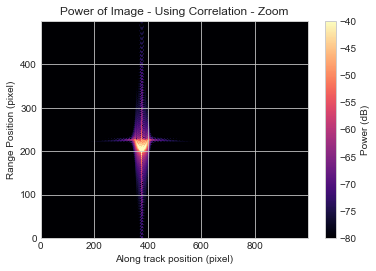

In [71]:
plt.imshow(20.*np.log10(np.abs(E_cr_rcac2[3000:3500,7500:8500])), cmap='magma', origin='lower', aspect='auto',vmax=-40.,vmin=-80.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Power of Image - Using Correlation - Zoom");

<a id="section-4.3"></a>
### 4.3 Azimuth Focusing - frequency domain

#### Preparation for Range Migration Correction

Note we have three corner reflectors located at unique ranges and azimuth locations.  It is a well known property of Fourier Transforms that a translation of position in one domain is equivalent to a phase ramp in the other domain.

$ \displaystyle\int f(t+\delta t) e^{-i \omega t} dt = \displaystyle\int f(t') e^{-i \omega (t'-\delta t)} dt = F(\omega)e^{i \omega\delta t} $

Therefore, by performing the Fourier transform of the range-compressed pulses in the azimuth direction will align the range-migration history *as a function of Doppler Frequency* of all ground points at a given range. Therefore if we express range as a function of Doppler frequency, then we can map the energy along the range curve to a constant range, nominally the closest approach range for broadside imaging, but it could be any constant range.  This will allow us to exploit the convolutional properties of Fourier transforms in the azimuth direction.

In [72]:
E_cr_rc_azfd = np.zeros((E_cr_rc.shape),dtype=np.complex128)

for i in range(E_cr_rc.shape[0]):                                      # correlate
    E_cr_rc_azfd[i,:] = np.fft.fft(E_cr_rc[i,:])

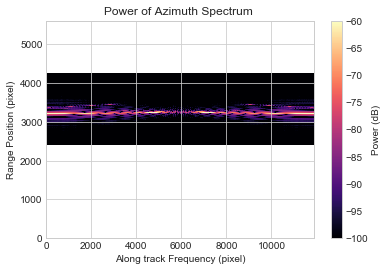

In [73]:
plt.imshow(20.*np.log10(np.abs(E_cr_rc_azfd)), cmap='magma', origin='lower', aspect='auto',vmax=-60.,vmin=-100.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track Frequency (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Power of Azimuth Spectrum ");

#### Next Coarsest Approximation: Frequency-domain Correlation with a Range-variable Reference Function; no Range Migration Correction

Now that we are in the frequency domain, we perform the equivalent of the time domain correlation by also transforming the reference function matrix, multiplying, then inverse transforming. In the correlation line using FFTs, we have combined many operations in one line:

* Shifting the Azimuth chirp by half its length to center it at 0 delay.  This centers the convolution properly. (roll function) 
* Perform FFT of it to put it in the spectral domain (remember it changes with each range)
* Multiply by the spectrum of the data at that range
* Inverse FFT to bring it back to the time domain. 

In [74]:
%%time

# the correlation by FFT; no range migration

E_cr_rcac_fd = np.zeros((E_cr_rc.shape),dtype=np.complex128) # initialize
C_az_REF_al = np.zeros(E_cr_rc.shape[1],dtype=np.complex128)

for i in range(n_rho_rc):                                    # correlate
    C_az_REF_al = np.zeros(E_cr_rc.shape[1],dtype=np.complex128)
    C_az_REF_al[0:C_az_ref.shape[1]] = np.conjugate(C_az_ref[i,:])
    E_cr_rcac_fd[i,:] = np.fft.ifft(np.fft.fft(E_cr_rc[i,:])*
                                    np.fft.fft(np.roll(C_az_REF_al,
                                                       -int(C_az_ref.shape[1]/2))))
    

CPU times: user 2min 45s, sys: 955 ms, total: 2min 46s
Wall time: 2min 46s


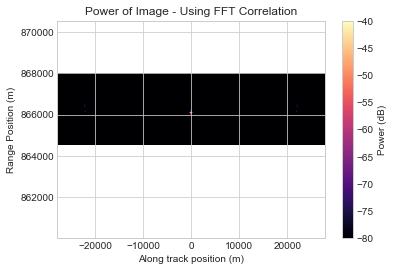

In [75]:
extent = [s_s_sim, s_e_sim, rho_s_rc, rho_e_rc]
plt.imshow(20.*np.log10(np.abs(E_cr_rcac_fd)), cmap='magma', extent=extent, origin='lower', aspect='auto',vmax=-40.,vmin=-80.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (m)")
plt.ylabel("Range Position (m)")
plt.title("Power of Image - Using FFT Correlation");

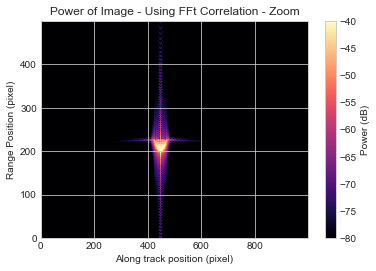

In [76]:
plt.imshow(20.*np.log10(np.abs(E_cr_rcac_fd[3000:3500,5500:6500])), cmap='magma', origin='lower', aspect='auto',vmax=-40.,vmin=-80.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Power of Image - Using FFt Correlation - Zoom");

#### Range Migration Correction

Now in the Fourier domain in azimuth above, we can see that there is a migration of the brightness to larger range as frequency increases (zero is at the left and right edges of the above image).  This will be the case independent of the number and azimuth location of the corner reflectors.  They all collapse back to a migration curve centered on zero frequency at the appropriate range.  If there is squint, the migration curve will still be centered on zero frequency, but there will only be energy in the portion of the spectrum dictated by the antenna beam.  We can use the range-Doppler relationship to shift energy at a given Doppler frequency to its appropriate range bins. As described in Eq. (6)

\begin{equation}
\phi_{az}(s;\rho_0,s_0)  = -\frac{4\pi}{\lambda} \big(\rho(s;\rho_0,s_0) - \rho_0\big) = -\frac{4\pi}{\lambda} \bigg (\sqrt{(s-s_0)^2+\rho_0^2})- \rho_0\bigg)
\end{equation}

Noting that in our specialized geometry $s=v_{sc} t$, the time derivative of $\phi_{az}$ can be written

\begin{equation}
\omega_{az} = \frac{\partial}{\partial t} \phi_{az}(s;\rho_0,s_0) =  -\frac{4\pi}{\lambda} \cdot \frac{1}{2}\big ((s-s_0)^2+\rho_0^2 \big)^{-1/2}\cdot 2(s-s_0) \cdot v_{sc}
\end{equation}

Consolidating terms, and noting that $(s-s_0)^2 = \rho^2-\rho_0^2$, the Doppler frequency in Hertz is:

\begin{equation}
f_{hz,az} = \frac{\omega_{az}}{2\pi} = -\frac{2}{\lambda} \cdot \frac{1}{\rho} \big (\rho^2-\rho_0^2\big )^{1/2} \cdot v_{sc}
\end{equation}

or 

\begin{equation}
f^2_{hz,az} = -\frac{4}{\lambda^2} \cdot \frac{1}{\rho^2} \big (\rho^2-\rho_0^2\big ) \cdot v^2_{sc}
\end{equation}

This equation can be rearranged to solve for range as a function of doppler frequency:

\begin{equation}
\rho(f_{hz,az}) = \rho_0 \bigg (1-\frac{\lambda^2 f^2_{hz,az}}{4 v^2_{sc}}\bigg)^{-1/2}
\end{equation}

This can be reduced by Taylor expansion to the more familiar expression:

\begin{equation}
\rho(f_{hz,az}) \approx \rho_0 \bigg (1+\frac{\lambda^2 f^2_{hz,az}}{8 v^2_{sc}}\bigg)
\end{equation}


Equation (26) can be used to apply the correction in the azimuth frequency domain. For each Doppler Frequency bin, we need to differentially shift the range position of each point by a range dependent amount that brings all points on a migration curve to the same range bin.  This will allow proper compression of the energy in azimuth with no range migration loss.  

Because the Fourier Transform is on sampled data, the azimuth spectrum is circular, so if there is significant squint, we need to be careful to compute the range migration curve with respect to the beam edges in the Doppler domain.  The reference range will be the range at beam center, $\rho_{dc}$, not the closest approach range. The Doppler centroid as a function of range is given by

\begin{equation}
f_{dc}(\rho_{dc}) = \frac{2 v_{sc}}{\lambda} \sin\theta \sin\theta_{sq} = \frac{2 v_{sc}}{\lambda} \sin\bigg(\cos^{-1}\bigg(\frac{h_{sc}}{\rho_{dc}}\bigg)\bigg) \sin\theta_{sq}
\end{equation}
and the limits in the azimuth spectrum where it has significant energy is:

\begin{equation}
f_{dc,\pm}(\rho_{dc}) = f_{dc}(\rho_{dc}) \pm \frac{f_{az,bw}}{2}
\end{equation}

whereas the locations where the azimuth spectrum of the signal would have wrap points relative to the centroid are given by:

\begin{equation}
f_{dc,\pm,f_s}(\rho_{dc}) = f_{dc}(\rho_{dc})  \pm \frac{f_s}{2}
\end{equation}

Note that if there is a large squint, and the azimuth spectrum is critically sampled, then the indexing into the azimuth buffer is messy, because the wrap points must be computed in the circular array modulo the buffer length of the array, while the range migration curve must be computed in an absolute sense.  Note also that the negative frequencies are in the upper half of the array, so once the index is calculated, it must be adjusted.  If the azimuth spectrum is oversampled to begin with, one still must address the proper interpretation of positive and negative frequencies in the buffer, but wrapping of the spectrum would be avoided. For the sake if simplicity in this tutorial, we will assume that we don't need to address the spectral wrapping, i.e. that we are either at zero squint or the spectrum is oversampled.  If this is not the case, the range migration correction will not be correct.


In [77]:
# calculate centroid as a function of range

def f_dc(rho):
    return 2. * v_sc * np.sin(np.arccos(h_sc/rho)) * np.sin(theta_sq) / Lambda

f_az_bw = v_sc * s_ov / Delta_s

# determine the range of frequencies in the spectrogram and define the meshgrid
# assumes that the spectrum array will be rotated to have -f_bw/2 at an array index if [0]

f_im = np.linspace(-f_az_bw/2.,f_az_bw/2.,E_cr_rc.shape[1])
F_im, Rho_rc = np.meshgrid(f_im,rho_rc)

# calculate the ambiguity of each of the frequencies in the spectrogram and add it to the frequency of each bin

F_abs = np.zeros((F_im.shape),dtype=np.int)
F_abs = F_im + f_az_bw * np.round((f_dc(Rho_rc)-F_im)/ (v_sc * s_ov / Delta_s)) 


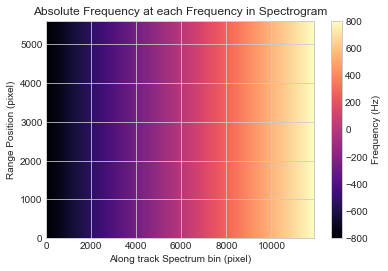

In [78]:
plt.imshow(F_abs, cmap='magma', origin='lower', aspect='auto')
plt.colorbar(label='Frequency (Hz)')
plt.xlabel("Along track Spectrum bin (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Absolute Frequency at each Frequency in Spectrogram");

In [79]:
# rotate the spectrum to work more easily in this domain
E_cr_rc_azfd_shift = np.zeros((E_cr_rc_azfd.shape),dtype=np.complex128)
for i in range(E_cr_rc.shape[0]):                                      # correlate
    E_cr_rc_azfd_shift[i,:] = np.fft.fftshift(E_cr_rc_azfd[i,:])

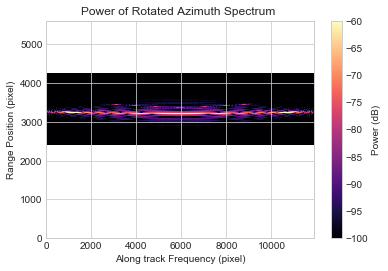

In [80]:
plt.imshow(20.*np.log10(np.abs(E_cr_rc_azfd_shift)), cmap='magma', origin='lower', aspect='auto',vmax=-60.,vmin=-100.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track Frequency (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Power of Rotated Azimuth Spectrum ");

Now that we have the absolute frequency calculated for each range, and the spectrum rotated to match it, we are a position to perform the range migration correction for each frequency.


In [81]:
Rho_rm = np.zeros((F_im.shape),dtype=np.int)
Rho_rm = Rho_rc * (np.cos(theta_sq) / np.sqrt(1.- Lambda**2 * F_abs**2/ (4. * v_sc**2)))
Rho_rm_nn = np.zeros((F_im.shape),dtype=np.complex128)
Rho_rm_nn = np.round((Rho_rm-rho_rc[0])*rho_ov/Delta_rho).astype(int)


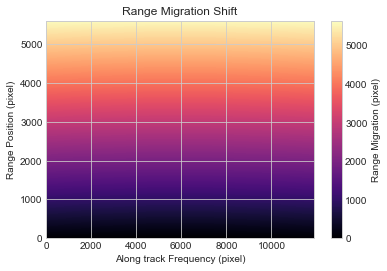

In [82]:
plt.imshow(Rho_rm_nn, cmap='magma', origin='lower', aspect='auto')
plt.colorbar(label='Range Migration (pixel)');
plt.xlabel("Along track Frequency (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Range Migration Shift");

We are now ready to use this range migration map to resample the spectrum.  The spectral wrap cut (which will not appear in the zero squint geometry) presents a bookkeeping challenge.  For this tutorial we simply ignore it and interpolate across it.  This will introduce artifacts, but using a nearest neighbor interpolator will mitigate some of the edge effects. 

In [83]:
%%time

# for each frequency, use sinc interpolator to move data in range.
E_cr_rc_azfd_rm = np.zeros((E_cr_rc_azfd.shape),dtype=np.complex128)
for i in range(E_cr_rc_azfd_rm.shape[0]):
    for j in range(E_cr_rc_azfd_rm.shape[1]):
        E_cr_rc_azfd_rm[i,j] = E_cr_rc_azfd_shift[min(Rho_rm_nn[i,j],E_cr_rc_azfd_rm.shape[0]-1),j]

CPU times: user 1min 9s, sys: 687 ms, total: 1min 9s
Wall time: 1min 9s


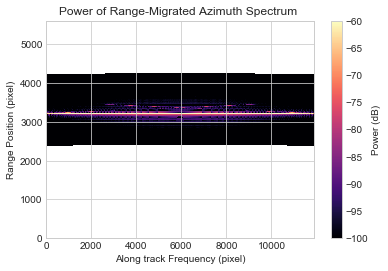

In [84]:
plt.imshow(20.*np.log10(np.abs(E_cr_rc_azfd_rm)), cmap='magma', origin='lower', aspect='auto',vmax=-60.,vmin=-100.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track Frequency (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Power of Range-Migrated Azimuth Spectrum ");

#### Reference Function Application and Inverse Azimuth Transform to the Image



It clear that the energy has been migrated to constant range, which will should improve the correlation result.  Let's see. 

In [85]:
# rotate the spectrum back to original position
E_cr_rc_azfd_rm_shift = np.zeros((E_cr_rc_azfd.shape),dtype=np.complex128)
for i in range(E_cr_rc.shape[0]):                                      # correlate
    E_cr_rc_azfd_rm_shift[i,:] = np.fft.fftshift(E_cr_rc_azfd_rm[i,:])

In [86]:
%%time

# the correlation by FFT; with range migration

E_cr_rcac_fd_rm = np.zeros((E_cr_rc.shape),dtype=np.complex128) # initialize
C_az_REF_al = np.zeros(E_cr_rc.shape[1],dtype=np.complex128)

for i in range(n_rho_rc):                                    # correlate
    C_az_REF_al = np.zeros(E_cr_rc.shape[1],dtype=np.complex128)
    C_az_REF_al[0:C_az_ref.shape[1]] = np.conjugate(C_az_ref[i,:])
    E_cr_rcac_fd_rm[i,:] = np.fft.ifft(E_cr_rc_azfd_rm_shift[i,:]*
                                    np.fft.fft(np.roll(C_az_REF_al,
                                                       -int(C_az_ref.shape[1]/2))))
    

CPU times: user 1min 51s, sys: 1.48 s, total: 1min 52s
Wall time: 1min 53s


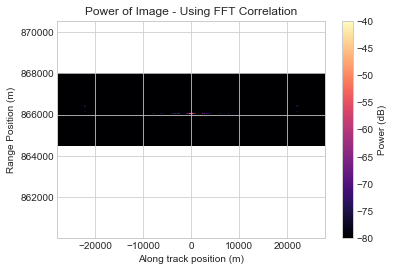

In [87]:
extent = [s_s_sim, s_e_sim, rho_s_rc, rho_e_rc]
plt.imshow(20.*np.log10(np.abs(E_cr_rcac_fd_rm)), cmap='magma', extent=extent, origin='lower', aspect='auto',vmax=-40.,vmin=-80.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (m)")
plt.ylabel("Range Position (m)")
plt.title("Power of Image - Using FFT Correlation");

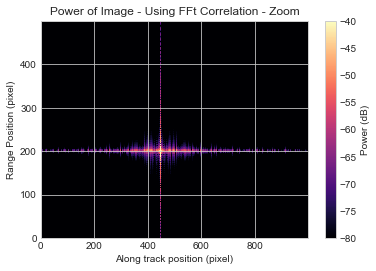

In [88]:
plt.imshow(20.*np.log10(np.abs(E_cr_rcac_fd_rm[3000:3500,5500:6500])), cmap='magma', origin='lower', aspect='auto',vmax=-40.,vmin=-80.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Power of Image - Using FFt Correlation - Zoom");

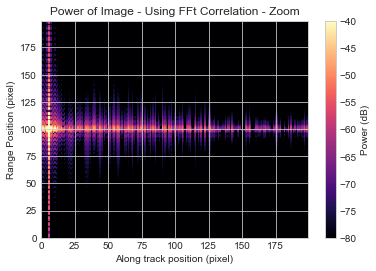

In [89]:
plt.imshow(20.*np.log10(np.abs(E_cr_rcac_fd_rm[3100:3300,5940:6140])), cmap='magma', origin='lower', aspect='auto',vmax=-40.,vmin=-80.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Power of Image - Using FFt Correlation - Zoom");

As can be seen, the energy is much better focused with range migration correction than without. The noise structure in the sidelobes is due to the poor nearest neighbor interpolator in azimuth migration.  This would be improved with a better interpolator, since as a sinc interpolator.  The sinc interpolator included in this notebook runs very slowly, however.

<a id="section-4.4"></a>
### 4.4 Back Projection Time-Domain Processing in Azimuth

The range compressed response of a corner reflector was described above as:

\begin{equation}
E_{cr,rc}(s,\rho; s_{cr}, \rho_{cr}) = K \sqrt{G_T} e^{-i 4\pi(\rho_{\rm sc-cr}-\rho_{l})/\lambda} {\rm sinc}\big(\frac{\rho-\rho_{\rm sc-cr}}{\Delta\rho}\big)
\end{equation}

where $\rho_{\rm sc-cr}$ would be the appropriate range for when the point was observed (including squint), and $s_cr$ the corresponding azimuth position.  Let's focus on the complex hyperbolic phase that we explored above when discussing the phase history of a point over time.

\begin{equation}
E_{cr,rc}(s,\rho; s_{cr}, \rho_{cr}) = K \sqrt{G_T} e^{-i 4\pi\big(\sqrt{(s-s_{cr})^2+\rho_{cr}^2}-\rho_{l}\big)/\lambda} {\rm sinc}\big(\frac{\rho-\rho_{\rm sc-cr}}{\Delta\rho}\big)
\end{equation}

If we generalize $s_{cr}, \rho_{cr}$ to any image point $[s_i,\rho_i]$, this relationship of range to azimuth remains:

\begin{equation}
\rho (s) = \sqrt{(s-s_i)^2+\rho_i^2}
\end{equation}

In our idealized geometry, with the spacecraft flying a straight line above a flat earth, $\rho_i$ is not a function of $s_i$ (no topography, no variable distance from orbit to ground), so $\rho(s)$ is the same function for any $s_i$ at a given $\rho_i$, but varies with $\rho_i$.

Therefore, to gather the energy in azimuth to focus the image at point $(s_i,\rho_i)$, we simply look up the sample in the range compressed echoes corresponding for each $s$ and $\rho$ in the synthetic aperture, compensate the propagation phase delay at each point, then sum all points in the synthetic aperture. Since the sample points are not necessarily perfectly aligned, we would ideally interpolate the echoes to get the exact values at $(s,\rho)$.  However, for the purpose of this tutorial, we will just take the nearest neighbor echo sample. First we define the image grid to be smaller than the simulation grid sufficiently to avoid edge effects.

In [90]:
# define the image grid - trim relative to simulation
# in range, trim by pulse duration

rho_s_im =  rho_s_sim + c * tau_r/2.
rho_e_im =  rho_e_sim - c * tau_r/2.
n_rho_im = int(np.round((rho_e_im-rho_s_im)* rho_ov/Delta_rho))
rho_im = np.linspace(rho_s_im,rho_e_im,n_rho_im)

# in azimuth, trim by half a beamwidth
s_s_im = s_s_sim + rho_f * theta_L_a / 2.
s_e_im = s_e_sim - rho_f * theta_L_a / 2.    
n_s_im = int(np.round((s_e_im-s_s_im)* s_ov/Delta_s))  
s_im = np.linspace(s_s_im,s_e_im,n_s_im)
S_im, Rho_im = np.meshgrid(s_im,rho_im)

Next define the synthetic aperture extents.  These vary with range, and need to take into account any azimuth squint. We did this above when defining the azimuth reference function for the correlation approach.  Once again, for a point at $(s_{im},\rho_{im})$ observed with squint $\theta_{sq}$, the range of closest approach of the spacecraft when the boresight intersects this point is given by

$ \rho_{ca} = \rho_{im} \cos\theta_{sq}$ 

and the along-track position of this point relative to closest approach is

$s_{ca-rel} = \rho_{ca} \tan \theta_{sq}$

The limits of the synthetic aperture then are given by the angle subtended around this squint angle:

$s_{s,sa} = \rho_{ca} \tan (\theta_{sq} - \theta_{L_a}/2) \qquad s_{e,sa} = \rho_{ca} \tan (\theta_{sq} + \theta_{L_a}/2)$

$\rho_{s,sa} = \rho_{ca} / \cos(\theta_{sq}-\theta_{L_a}/2) \qquad \rho_{e,sa} = \rho_{ca} / \cos(\theta_{sq}+\theta_{L_a}/2)$

In [91]:
# define the synthetic aperture extents across range
# first the closest approach range and azimuth for a given squinted slant range
rho_ca = rho_im * np.cos (theta_sq)
s_carel = rho_ca * np.tan(theta_sq)

# Next the start and end extents for each of these points relative to s_im
s_s_sa  =  rho_ca * np.tan(theta_sq-theta_L_a/2.) # half beamwidth, w/ squint, relative to s_im
s_e_sa  =  rho_ca * np.tan(theta_sq+theta_L_a/2.) # half beamwidth, w/ squint, relative to s_im
n_s_sa = np.round((s_e_sa-s_s_sa)* s_ov/Delta_s).astype(int)

rho_s_sa = rho_ca / np.cos(theta_sq-theta_L_a/2)
rho_e_sa = rho_ca / np.cos(theta_sq+theta_L_a/2)
n_rho_sa = np.round((rho_e_sa-rho_s_sa)* s_ov/Delta_s).astype(int)

For a given image point, $(s_{im},\rho_{im})$ in the image of points $[s_{im},\rho_{im}]$, coordinates over which to integrate the echoes are $(s,\rho(s)) = (s,\sqrt{(s-s_{im})^2+\rho^2_{im}})$.  Thus the time domain back projection processing will be
\begin{equation}
E_{cr,td}(s_{im},\rho_{im}) = \displaystyle \int_{s_{im}+s_{s,sa}}^{s_{im}+s_{e,sa}} E_{cr,rc}(s,\rho(s)) e^{i 4 \pi \rho(s) /\lambda} ds
\end{equation}

with $s_{s,sa}$ and $s_{e,sa}$ defined above as image point-relative extents of the synthetic aperture.  Note we can get away with calculating the $\rho(s)$ function once per range bin because of the regular rectilinear motion with no topography.  You will rapidly find if you execute the next block that it takes *forever* due to the triple loop and the python-interpreted indexing.  You will need to interrupt the run to uncomment the limits specified around each of the corner reflectors to perform only the necessary calculations.

In [92]:
%%time

E_cr_im = np.zeros((n_rho_im,n_s_im),dtype=np.complex128) # initialize output grid

# Calculate computable limits +/- 200 m
bp_win = 200.
#
ns_s_im_cr = np.round((S_cr - bp_win - s_s_im)*s_ov/Delta_s).astype(int)
ne_s_im_cr = np.round((S_cr + bp_win - s_s_im)*s_ov/Delta_s).astype(int)
ns_rho_im_cr = np.round((Rho_cr - bp_win - rho_s_im)*rho_ov/Delta_rho).astype(int)
ne_rho_im_cr = np.round((Rho_cr + bp_win - rho_s_im)*rho_ov/Delta_rho).astype(int)
for ncr in range(len(Ind_cr)):
    print ("Reflector ",Ind_cr[ncr],ns_s_im_cr[Ind_cr[ncr]],
           ne_s_im_cr[Ind_cr[ncr]],ns_rho_im_cr[Ind_cr[ncr]],ne_rho_im_cr[Ind_cr[ncr]])

    for rho_im_b in range(ns_rho_im_cr[Ind_cr[ncr]],ne_rho_im_cr[Ind_cr[ncr]]):
        if(np.mod(rho_im_b,10)==0): print (rho_im_b)
        s_sa = np.linspace(s_s_sa[rho_im_b],s_e_sa[rho_im_b],n_s_sa[rho_im_b])
        rho_sa = np.sqrt(rho_im[rho_im_b]**2+(s_sa)**2)
        azref = np.exp(1j*4.*np.pi*rho_sa/Lambda) # conjugate of observed phase history
        for s_im_b in range(ns_s_im_cr[Ind_cr[ncr]],ne_s_im_cr[Ind_cr[ncr]]):
            E_cr_rc_bp=np.zeros(n_s_sim,dtype=np.complex128)
            azref_bp=np.zeros(n_s_sim,dtype=np.complex128)
            for sb in range(len(s_sa)):
                sb_rc = int(np.round((s_im[s_im_b]+s_sa[sb]-s_s_sim)*s_ov/Delta_s))
                rhob_rc = int(np.round((rho_sa[sb]-rho_s_sim)*rho_ov/Delta_rho))
                E_cr_rc_bp[sb_rc]=E_cr_rc[rhob_rc,sb_rc]
                azref_bp[sb_rc]=azref[sb]
            E_cr_im[rho_im_b,s_im_b] += np.dot(E_cr_rc_bp,azref_bp)

Reflector  1 3921 4007 2293 2507
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
CPU times: user 7min 39s, sys: 1.18 s, total: 7min 40s
Wall time: 7min 41s


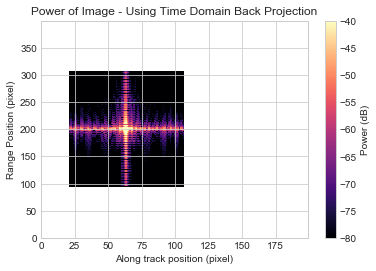

In [93]:
plt.imshow(20.*np.log10(np.abs(E_cr_im[2200:2600,3900:4100])), cmap='magma', origin='lower', aspect='auto',vmax=-40.,vmin=-80.)
plt.colorbar(label='Power (dB)');
plt.xlabel("Along track position (pixel)")
plt.ylabel("Range Position (pixel)")
plt.title("Power of Image - Using Time Domain Back Projection");

## Summary

This tutorial covers the following topics:

* SAR Geometry
* Antenna Patterns
* The Radar Equation
* Doppler and Phase in the synthetic aperture
* Range reference function and correlation to achieve fine range resolution
    - Range correlation in the time domain 
    - Range correlation using FFTs to perform circular correlation
* Azimuth reference function and correlation 
    - Azimuth correlation in the time domain 
    - Azimuth migration correction
    - Azimuth correlation using FFTs to perform circular correlation
    - Backprojection in the time domain
    
While the geometry is idealized, through this step-by-step approach with python code to simulate radar echoes from point targets and a variety of methods to process the data, the notebook illustrates the meaning of the synthetic aperture, the explicit signal properties of the return echoes, and how the varying range of a target from pulse to pulse necessitates a some resampling to align the energy with a regular grid.  

The notebook is designed to allow the student to adjust parameters to alter resolution, squint, geometry, radar elements such as antenna dimensions, and other factors. Some of these can be done locally, others must be done at the beginning of the notebook. Once the student is familiar with the cell dependencies, these will become clear.  For example, resolution of the simulation and other geometric parameters must be set at the beginning.  Plot dimensions, and processing choices once the simulation is established can be set locally.  A successful learning outcome would be confidence in understanding where parameters need to change to affect the tutorial in a particular way. 